# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score
import re
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('train.csv')

# Taking care of the missing data from the training data 

In [3]:
missing=df.isnull().sum()
print(missing)

user_name             19393
country                  35
review_title              0
review_description        0
designation           23647
points                    0
price                  5569
province                 35
region_1              12754
region_2              46708
winery                    0
variety                   0
dtype: int64


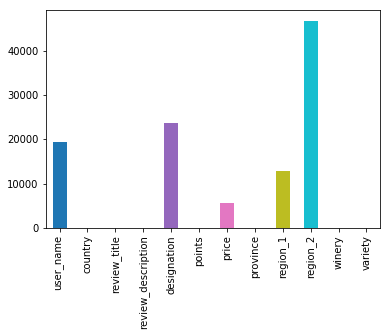

In [4]:
missing.plot.bar()

Out of the 82657 samples in the training dataset we observe that features like 'user_name', 'desgination', 'region_1' and 'region_2' have missing string samples over 12,000. Replacing these missing features with the most frequent elemnt is only going to hamper the accuracy of the our model. So we've dropped these features from our training dataset.

In [5]:
del df['user_name']
del df['designation']
del df['region_1']
del df['region_2']

In [6]:
df.isnull().sum()

country                 35
review_title             0
review_description       0
points                   0
price                 5569
province                35
winery                   0
variety                  0
dtype: int64

To deal with missing data in price, we've replaced the missing data with the mean of the entire 'price' column in the dataset. The missing elements in 'country' and 'province' are very small in number with respect to the size of data. Therefore, here we have replaced the missing elements with the most frequent element in that particular feature.


In [7]:
df['price']=df.price.fillna(df.price.mean())
df['country'] = df.country.fillna(df.country.value_counts().index[0])
df['province'] = df.province.fillna(df.province.value_counts().index[0])
df.isnull().sum() 

country               0
review_title          0
review_description    0
points                0
price                 0
province              0
winery                0
variety               0
dtype: int64

No missing data here.

In [8]:
df.head()

,country,review_title,review_description,points,price,province,winery,variety
0,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",83,10.0,Australia Other,Andrew Peace,Chardonnay
1,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,89,15.0,Washington,North by Northwest,Red Blend
2,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,94,80.0,Piedmont,Renato Ratti,Nebbiolo
3,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,87,22.0,Southwest France,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",88,33.0,France Other,Château du Cèdre,Malbec


# Analysis on the dependent variable: variety 

In [9]:
df.variety.value_counts()

Pinot Noir                    10587
Chardonnay                     9403
Cabernet Sauvignon             7552
Red Blend                      7166
Bordeaux-style Red Blend       5497
Riesling                       4148
Sauvignon Blanc                4011
Syrah                          3316
Rosé                           2831
Merlot                         2471
Nebbiolo                       2242
Zinfandel                      2209
Sangiovese                     2165
Malbec                         2119
Portuguese Red                 1969
White Blend                    1896
Sparkling Blend                1739
Tempranillo                    1448
Rhône-style Red Blend          1182
Pinot Gris                     1148
Champagne Blend                1133
Cabernet Franc                 1095
Grüner Veltliner               1055
Portuguese White                896
Pinot Grigio                    873
Bordeaux-style White Blend      850
Gewürztraminer                  840
Gamay                       

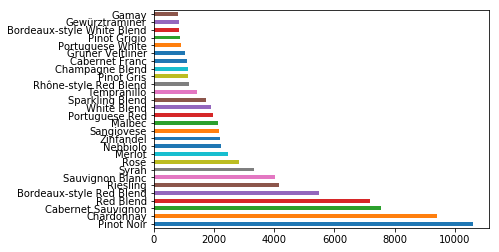

In [10]:
dt=df.variety.value_counts()
dt.plot.barh()

# Average Rating: Are the users loving the service?

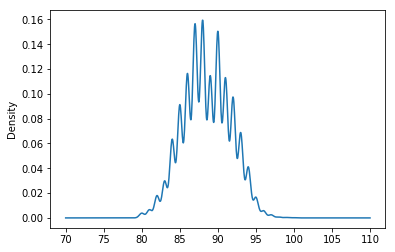

In [11]:
points=df.points
points.plot.density()

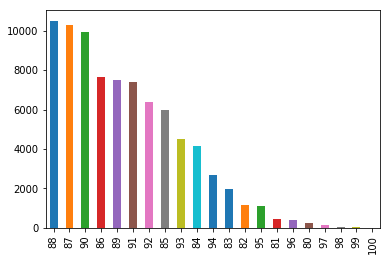

In [12]:
points=df.points.value_counts()
points.plot.bar()

In [13]:
df.points.mean()

88.54456367881728

In [14]:
df.points.median()

88.0

The minimum rating received is 88 (out of 100) which is very commendable as the dataset contains 80,000+ samples.

# Preprocessing the string columns of the data

Preprocessing the strings here

In [15]:
def preprocess(sms):
  pattern = re.compile('[^[A-Za-z\s]')
  sms = re.sub(pattern,' ',sms)
  sms = re.sub('\s+',' ',sms)
  sms = sms.lower()
  return sms

In [16]:
df['review_title']= df['review_title'].map(lambda x :preprocess(x))
df['review_description']= df['review_description'].map(lambda x :preprocess(x))

Taking care of the stopwords

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review_title'] = df['review_title'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['review_description'] = df['review_description'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [18]:
df.head()

,country,review_title,review_description,points,price,province,winery,variety
0,Australia,andrew peace peace family vineyard chardonnay ...,classic chardonnay aromas apple pear hay lead ...,83,10.0,Australia Other,Andrew Peace,Chardonnay
1,US,north northwest red columbia valley wa,wine near equal parts syrah merlot balance cab...,89,15.0,Washington,North by Northwest,Red Blend
2,Italy,renato ratti conca barolo,barolo conca opens inky dark concentration soo...,94,80.0,Piedmont,Renato Ratti,Nebbiolo
3,France,domaine l ancienne cure l abbaye white bergera...,impressive small addition sauvignon gris musca...,87,22.0,Southwest France,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,France,ch teau du c dre le c dre vintage malbec vin d...,ripe sweet wine rich full dried fresh fruit fl...,88,33.0,France Other,Château du Cèdre,Malbec


# Splitting the dataset

In [19]:
nlp=df['review_title']+df['country']+df['province']+df['review_description']+df['winery']
y = df.variety
X_train, X_val, y_train, y_val = train_test_split(nlp, y, test_size = 0.25, random_state = 0)

# Vectorization of the string after preprocessing

In [20]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

LinearSVC performed the best on the validation dataset after modeling the dataset on various classification algorithms like Logistic Regression, Naive Bayes, Random Forest, Decision Tree and rbf SVC. 

# Modeling the data

In [21]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
from sklearn import metrics
print(metrics.confusion_matrix(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred, digits=3))

[[1233    3    4   27    0    0    0    0    0    0    4    1    0    0
     4    6    0   82    0    0    0    0    0    0    2    0    0    0]
 [  20  164    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    7    0    0    0    6    0]
 [   1    0  252    2    1    0    0    0    0    0    1    0    0    0
     0    0    0    3    0    0    0    0    0    0    1    0    0    0]
 [  13    0    0 1901    0    0    0    0    0    1    3    0    0    0
     0    1    0   11    0    0    2    0    0    0    1    0    0    0]
 [   0    0    0    0  259    9    0    0    0    0    0    0    0    0
     4    0    0    0    0    0    3    1    5    6    0    0    0    0]
 [   2    0    0    0    2 2368    3    1    0    0    0    0    0    1
    13    0    0    0    0    1    0    0    2    5    0    0    1    0]
 [   2    0    0    0    0    2  200    0    0    0    0    0    0    0
     4    1    0    0    0    0    0    0    0    0    0  

Obtained F1 Score of 0.955 on validation dataset. 

Further, we eliminated the features one by one to see if there's some irrelavant feature. We found that the 'review_title' is sufficient enough to predict the 'variety' with an F1 score of 0.96

In [22]:
nlp=df['review_title']
y = df.variety
X_train, X_val, y_train, y_val = train_test_split(nlp, y, test_size = 0.25, random_state = 0)


In [23]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [24]:
from sklearn.svm import LinearSVC
classifier = LinearSVC(tol=1e-05,dual=False)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
from sklearn import metrics
print(metrics.confusion_matrix(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred, digits=3))
print(accuracy_score(y_val, y_pred))

[[1222    9    1    1    0    0    0    0    0    0    1    0    0    0
     0    2    0  124    4    0    0    0    2    0    0    0    0    0]
 [  42  145    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    3    0    0    0    7    0]
 [   0    0  260    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1    0]
 [   3    0    0 1929    0    0    0    0    0    0    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  282    1    0    0    0    0    0    0    0    0
     2    0    0    0    0    0    0    0    0    2    0    0    0    0]
 [   0    0    0    0    0 2349    5    0    0    0    0    0    0    0
    41    0    0    0    0    0    0    0    0    3    0    0    1    0]
 [   0    0    0    0    0    0  209    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0  

Obtained F1 Score of 0.964 on validation dataset after eliminating features like: 'review_description', 'winery', 'province' and 'country'

# Modeling on test dataset

In [25]:
test = pd.read_csv('test.csv')
dt=test['review_title'] # this feautre gave us the best F1 score on val dataset.

In [26]:
dt.isnull().sum()

0

In [27]:
X_test = vectorizer.transform(dt)

In [28]:
predictions = classifier.predict(X_test)
test['variety']=predictions
test.to_csv(r'C:\Users\Aman\Desktop\test_result.csv', index = False, header=True)

The corresponding predicted variety is saved in 'test_result.csv' file.